# Cornell Movie Review Data - Sentiment Analysis

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from nltk.tokenize import TweetTokenizer
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib  inline
from sklearn.metrics import precision_recall_curve
import matplotlib
from sklearn import metrics
from emoint.featurizers.emoint_featurizer import EmoIntFeaturizer
from emoint.ensembles.blending import blend

In [2]:
def list_files(base_path, predicate):
    for folder, subs, files in os.walk(base_path):
        for filename in files:
            if predicate(os.path.join(folder, filename)):
                yield (os.path.join(folder, filename))

In [3]:
def get_xy(path):
    X = []
    y = []
    
    featurizer = EmoIntFeaturizer()
    tokenizer = TweetTokenizer()
    
    for f in list_files(path, lambda x: x.endswith('.txt')):
        data = open(f).read()
        
        tokens = tokenizer.tokenize(data)
        features = featurizer.featurize(tokens)
        X.append(features)
        
        if os.path.dirname(f).endswith('pos'):
            y.append(1)
        else:
            y.append(0)
    
    X = np.array(X)
    y = np.array(y)
    
    # shuffle the data
    np.random.seed(0)
    idx = np.random.permutation(y.size)
    X = X[idx]
    y = y[idx]
    
    print("X shape: {}".format(X.shape))
    print("y shape: {}".format(y.shape))
    
    return X, y, featurizer.features

In [4]:
X, y, features = get_xy('/Users/venkatesh/Downloads/review_polarity/')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X shape: (2000, 455)
y shape: (2000,)


In [5]:
def train(X_train, y_train, X_test, y_test):
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    acc = accuracy_score(y_test_pred, y_test)
    print("Accuracy: {}".format(acc))
    return clf

def plot_fig(regr, labels, title):
    indices = np.argsort(regr.feature_importances_)[-10:]
    std = np.std([regr.feature_importances_ for x in regr.estimators_], axis=0)
    plt.barh(np.arange(len(indices)), regr.feature_importances_[indices], color="b", yerr=std[indices])
    plt.yticks(np.arange(len(indices)) + 0.75/2 , np.array(labels)[indices])
    plt.xlabel('Relative importance')
    plt.title(title)

Accuracy: 0.71


/Users/venkatesh/tensorflow/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


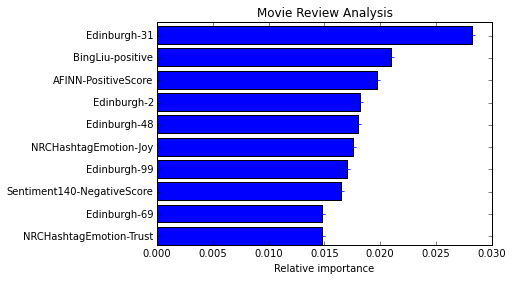

In [6]:
np.random.seed(0)
regr = train(X_train, y_train, X_test, y_test)
plot_fig(regr, features, "Movie Review Analysis")

In [7]:
clfs = [RandomForestClassifier(), ExtraTreesClassifier(), BaggingClassifier(), GradientBoostingClassifier()]
y_test_prob = blend(X_train, y_train, X_test, clfs, regr=False)

In [8]:
def helper(fig, x, y, _xlabel, _ylabel, _label, _title, subnum, loc="lower left"):
    fig.add_subplot(subnum)
    fig.subplots_adjust(hspace=.5)
    plt.plot(x, y, label=_label)
    plt.xlabel(_xlabel)
    plt.ylabel(_ylabel)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(_title)
    plt.legend(loc=loc)


def plot_pr_curves(y_test, test_pred):
    fig = plt.figure(figsize=(10, 6))
    precision, recall, threshold = precision_recall_curve(y_test, test_pred)
    threshold = np.append(threshold, [1])
    fpr, tpr, _ = metrics.roc_curve(y_test, test_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    helper(fig, recall, precision, 'Recall', 'Precision',
           'Precision-Recall curve', 'Precision-Recall', 221)
    helper(fig, threshold, precision, 'Threshold', 'Precision',
           'Precision-Threshold curve', 'Precision-Threshold', 222)
    helper(fig, threshold, recall, 'Threshold', 'Recall',
           'Recall-Threshold curve', 'Recall-Threshold', 223)
    helper(fig, fpr, tpr, 'True Positive Rate', 'False Positive Rate', 'AUC = %0.2f' % roc_auc,
           'Receiver Operating Characteristic', 224, loc="lower right")
    plt.plot([0.0, 1.0], [0.0, 1.0], 'r--')

Accuracy: 0.7425


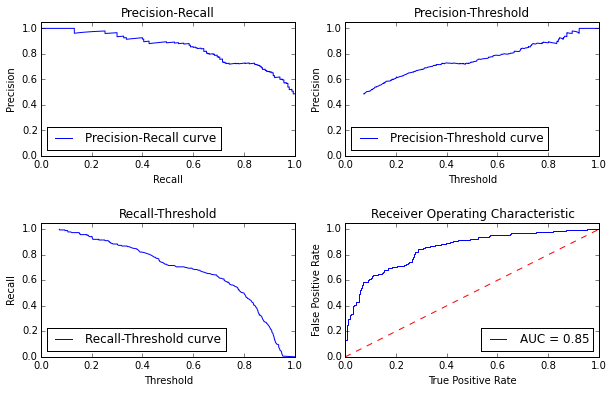

In [9]:
plot_pr_curves(y_test, y_test_prob)

y_test_pred = np.array(y_test_prob)
y_test_pred[y_test_prob >= 0.5] = 1
y_test_pred[y_test_prob < 0.5] = 0

print("Accuracy: {}".format(accuracy_score(y_test_pred, y_test)))